# Introduction

This notebook presents a comprehensive data analysis pipeline designed for high-dimensional single-cell RNA-seq (scRNA-seq) datasets. The objective of this analysis is to familiarize with high-dimensional datasets, dimensionality reduction techniques, and unsupervised learning methods for identifying single-cell states. We will be working with a pre-processed scRNA-seq dataset containing expression data from 137 cells and 54,675 genes, called `RNA-seq.csv`.

The pipeline will be implemented in a separate Python codebase (`codebase.py`), and this notebook will be used to present the analysis and results. The pipeline includes three main tasks:
1. __Dimensionality Reduction__ of the expression data using a variety of methods (PCA, t-SNE, UMAP)
2. __Clustering__ of the dimensionality-reduced data (resulting from each of the three methods) into the optimal number of cell groups (cell "states") using different clustering algorithms (GMMs, DBSCAN) and different model selection techniques (BIC, Silhouette score)
3. __Visualization__ of the results, including inferred clusters and cell posteriors probabilities (for GMMs), in an intuitive manner for a human investigator

## The `DataPipeline` Class Overview

The `DataPipeline` class processes, reduces dimensionality, clusters, and visualizes single-cell RNA-seq data. It supports PCA, t-SNE, UMAP for dimensionality reduction and GMM, DBSCAN for clustering.

<ins>Methods</ins>
* `dimensionality_reduction`: Performs PCA, t-SNE, and UMAP dimensionality reduction
* `optimize_tsne`: Optimizes t-SNE embedding using specified parameters
* `optimize_umap`: Optimizes UMAP embedding using specified parameters
* `plot_dimensionality_reduction`: Plots 2D and 3D embeddings of specified methods
* `clustering`: Performs clustering on reduced data using GMM and/or DBSCAN
* `plot_clustering_results`: Plots clustering results in 2D and 3D for specified methods and algorithms
* `plot_posterior_probabilities`: Plots posterior probabilities heatmap for GMM clustering

In [ ]:
# Importing necessary libraries
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../src')
from codebase import DataPipeline

In [21]:
# Initializing the pipeline and viewing the preprocessed data
data_pipeline = DataPipeline('../data/RNA-seq.csv')
data_pipeline.data

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
cells,,,,,,,,,,,,,,,,,,,,,
cell_84,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,8.870780,3.278896,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
cell_85,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,7.767646,3.589636,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
cell_87,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,9.417956,3.552253,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
cell_90,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,9.022345,3.312473,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
cell_91,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,9.400056,3.368243,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_230,10.392638,7.334408,6.848586,7.020486,3.228065,7.815439,5.448470,4.496955,8.015534,4.126711,...,12.638556,12.122129,14.331152,14.133976,8.495888,4.971727,6.209136,2.852852,3.697448,3.333289
cell_233,10.930875,8.415294,5.906827,7.753572,3.270557,7.367931,5.906849,5.194349,8.248133,3.735215,...,12.523507,11.977970,14.285405,14.070989,8.193182,6.528948,7.108210,2.929800,3.833289,3.213893
cell_236,11.027098,7.180876,6.304736,7.641197,3.206950,8.569296,5.823146,4.617309,7.523521,3.718392,...,12.256767,11.661126,14.149586,13.977076,8.351331,6.882504,7.329545,3.085127,3.628848,3.215807


In [22]:
# Viewing information about the data
data_pipeline.data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, cell_84 to cell_238
Columns: 54675 entries, 1007_s_at to AFFX-TrpnX-M_at
dtypes: float64(54675)
memory usage: 57.1+ MB


# Dimensionality Reduction

## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique used to transform a large set of variables into a smaller set while retaining most of the original variability in the data. It achieves this by identifying the directions, or principal components, along which the variance of the data is maximized. The process involves standardizing the data, computing the covariance matrix, calculating the eigenvalues and eigenvectors, sorting these eigenvalues, selecting the top components that capture the most variance, and finally projecting the original data onto these principal components to obtain a reduced dataset.

PCA is particularly useful for scRNA-seq data, which is often high-dimensional and noisy, making direct analysis challenging. By reducing the dimensionality, PCA simplifies the dataset while retaining significant features, reduces noise by focusing on the principal components that capture the most variance, and facilitates visualization, helping to identify patterns and clusters. To optimize PCA, one can select the best number of components using methods like calculating the cumulative explained variance, plotting a scree plot to identify the "elbow point," or using cross-validation to determine the optimal number of components that best represent the data without overfitting.

In this implementation, the optimal number of PCA components is found based on the cumulative explained variance criterion, with a threshold of 90% of the total variance:

Number of components selected for PCA: 87


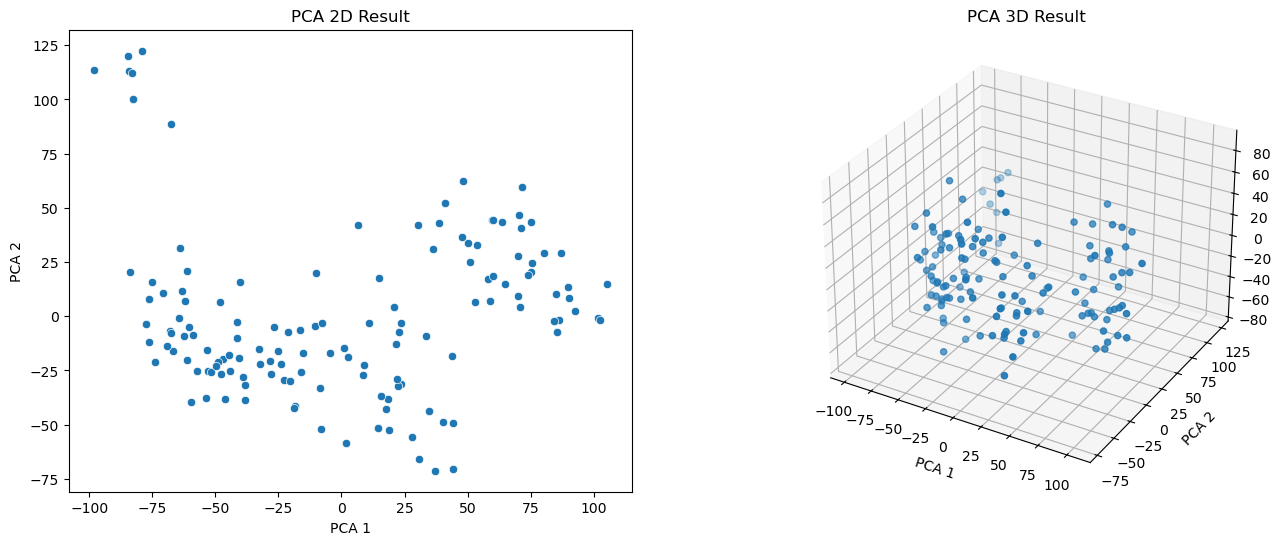

In [23]:
# Dimensionality reduction with PCA
data_pipeline.dimensionality_reduction(methods=['PCA'], variance_threshold=0.9)

# Plotting PCA dimensionality reduction results in 2D and 3D
data_pipeline.plot_dimensionality_reduction(methods=['PCA'])

## t-distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a powerful dimensionality reduction technique designed to visualize high-dimensional data in a lower-dimensional space (usually 2D or 3D) while preserving the local structure of the data. This means t-SNE maintains the relative distances between similar objects, effectively keeping them close together in the new space. It works by converting high-dimensional Euclidean distances between data points into conditional probabilities that represent similarities, using a Gaussian distribution in the high-dimensional space and a Student's t-distribution in the low-dimensional space to address the "crowding problem."

For single-cell RNA-seq data analysis, t-SNE is particularly useful due to its ability to manage the high dimensionality of gene expression levels across many cells. This makes it easier to visualize clusters of similar cells, identify different cell types, and observe gene expression patterns, which is crucial for understanding cellular heterogeneity and discovering new cell types. Optimizing t-SNE involves selecting appropriate parameters, including perplexity (which balances attention between local and global aspects of the data), learning rate (which affects the optimization process), number of iterations (which influences convergence), and random state (which ensures reproducibility).

In this implementation, the optimal t-SNE parameters are determined using a grid search approach, testing combinations of perplexity and learning rate values while evaluating the quality of each resulting embedding using a trustworthiness metric, which measures how well the local structure of the data is preserved in the lower-dimensional space; the best parameters are selected based on the highest trustworthiness score, ensuring an effective and accurate representation of high-dimensional data for visualization and subsequent analysis.

Best t-SNE params for 2D: {'learning_rate': 100, 'n_iter': 2000, 'perplexity': 10, 'random_state': 42} with trustworthiness score: 0.9982176200984553
Best t-SNE params for 3D: {'learning_rate': 10, 'n_iter': 2000, 'perplexity': 10, 'random_state': 42} with trustworthiness score: 0.9984382957053132


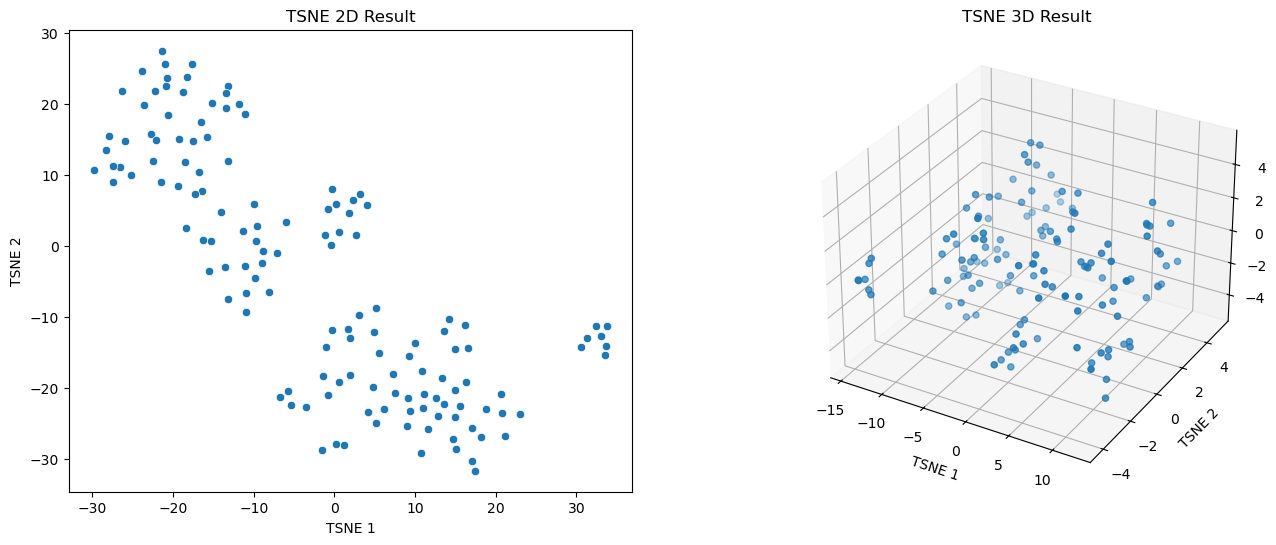

In [24]:
# Dimensionality reduction with t-SNE
data_pipeline.dimensionality_reduction(methods=['TSNE'])

# Plotting t-SNE dimensionality reduction results in 2D and 3D
data_pipeline.plot_dimensionality_reduction(methods=['TSNE'])

## Uniform Manifold Approximation and Projection (UMAP)

Uniform Manifold Approximation and Projection (UMAP) is a non-linear dimensionality reduction technique designed to visualize high-dimensional data by preserving its underlying structure. It constructs a high-dimensional graph where each data point connects to its nearest neighbors with edge weights reflecting distances. This graph is then optimized into a low-dimensional space using a force-directed layout algorithm that maintains the relationships from the high-dimensional space, balancing local and global structure preservation. This makes UMAP particularly effective for capturing the complex geometry of high-dimensional datasets.

In single-cell RNA-seq analysis, which involves thousands of genes, UMAP reduces dimensionality while retaining biological variance and structure, allowing for the identification and visualization of distinct cell populations, rare cell types, and cellular trajectories. Optimizing UMAP involves tuning hyperparameters like neighborhood size, minimum distance between points, number of dimensions, and a distance metric. 

In this implementation , the optimal UMAP parameters are determined using a grid search approach, testing various combinations of neighborhood size, minimum distance and distance metric values. This process involves creating embeddings for each parameter set and evaluating them using the same trustworthiness metric as before, which assesses how well the local structure of the high-dimensional data is preserved in the lower-dimensional embedding. The parameter set yielding the highest trustworthiness score is selected as the optimal configuration, ensuring UMAP is finely tuned for accurate and informative visualization of single-cell RNA-seq data.

Best UMAP params for 2D: {'metric': 'euclidean', 'min_dist': 0.1, 'n_neighbors': 5, 'random_state': 42} with trustworthiness score: 0.9980422112827477
Best UMAP params for 3D: {'metric': 'euclidean', 'min_dist': 0.75, 'n_neighbors': 5, 'random_state': 42} with trustworthiness score: 0.9981836700050926


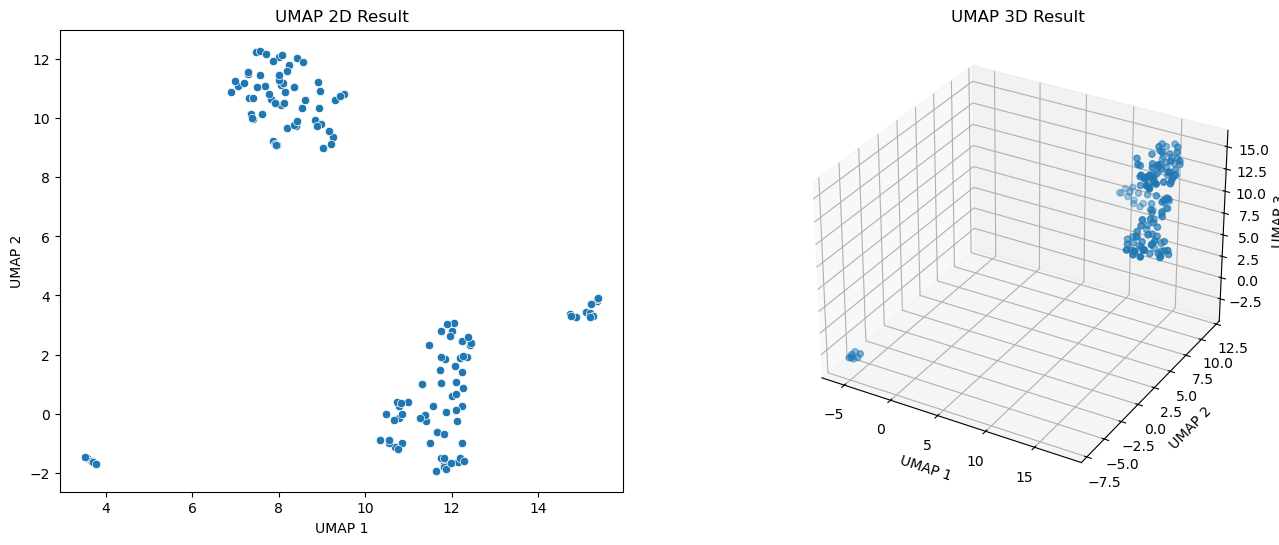

In [25]:
# Dimensionality reduction with UMAP
data_pipeline.dimensionality_reduction(methods=['UMAP'])

# Plotting UMAP dimensionality reduction results in 2D and 3D
data_pipeline.plot_dimensionality_reduction(methods=['UMAP'])

# Clustering Algorithms and Visualization

## Gaussian Mixture Model (GMM)

Gaussian Mixture Models (GMMs) are a probabilistic approach to clustering that assumes data points are generated from a mixture of several Gaussian distributions, each representing a different cluster. GMMs estimate the parameters of these distributions (means, variances, and mixing coefficients) using the Expectation-Maximization (EM) algorithm, iteratively refining the parameters to maximize the likelihood of the observed data. This method is particularly useful in single-cell RNA-seq data analysis because it can model the inherent variability and complexity of gene expression data. GMMs provide a probabilistic assignment of each cell to clusters, allowing for the identification of distinct cell populations and the calculation of posterior probabilities, which quantify the uncertainty of cell assignments to clusters.

The Bayesian Information Criterion (BIC) is a model selection criterion that balances model fit and complexity. It is calculated as $BIC = k \ln (n) - 2 \ln (L)$, where $k$ is the number of parameters in the model, $n$ is the number of data points, and $L$ is the maximum likelihood of the model. Lower BIC values indicate better models, striking a balance between good fitness and the risk of overfitting. In the context of our clustering analysis, BIC is used to evaluate GMMs with varying numbers of clusters and covariance structures. By selecting the model with the lowest BIC, we ensure that the chosen model is not only well-fitted to the data but also parsimonious, avoiding unnecessary complexity.

In this implementation, we apply GMMs with different numbers of components and covariance types for each reduced dataset (both 2D and 3D), while setting a random seed for reproducibility. We calculate the BIC for each model and select the model with the lowest BIC as the optimal clustering solution. This process is repeated separately for each dimensionality reduction method. The optimal number of clusters, cluster assignments, and posterior probabilities for each cell are determined. We also compute the silhouette score to evaluate the quality of each clustering solution and systematically select the best clustering result based on the highest silhouette score. Finally, we visualize the clustering results in 2D and 3D plots, as well as the posterior probabilities of each cell belonging to each cluster, and save the best clustering labels in the `labels.csv` file for further use.

In [85]:
# Clustering using GMMs
data_pipeline.clustering(clustering_algorithms=['GMM'], random_seed=89)

Clustering on PCA_2D
Optimal number of clusters for PCA_2D (GMM): 4
Silhouette Score for PCA_2D (GMM): 0.5143366107794277
Clustering on PCA_3D
Optimal number of clusters for PCA_3D (GMM): 4
Silhouette Score for PCA_3D (GMM): 0.3706474500897527
Clustering on TSNE_2D
Optimal number of clusters for TSNE_2D (GMM): 4
Silhouette Score for TSNE_2D (GMM): 0.5050413012504578
Clustering on TSNE_3D
Optimal number of clusters for TSNE_3D (GMM): 5
Silhouette Score for TSNE_3D (GMM): 0.4067734181880951
Clustering on UMAP_2D
Optimal number of clusters for UMAP_2D (GMM): 5
Silhouette Score for UMAP_2D (GMM): 0.7128146886825562
Clustering on UMAP_3D
Optimal number of clusters for UMAP_3D (GMM): 5
Silhouette Score for UMAP_3D (GMM): 0.4599240720272064
Best labels saved from UMAP_2D method using GMM algorithm.


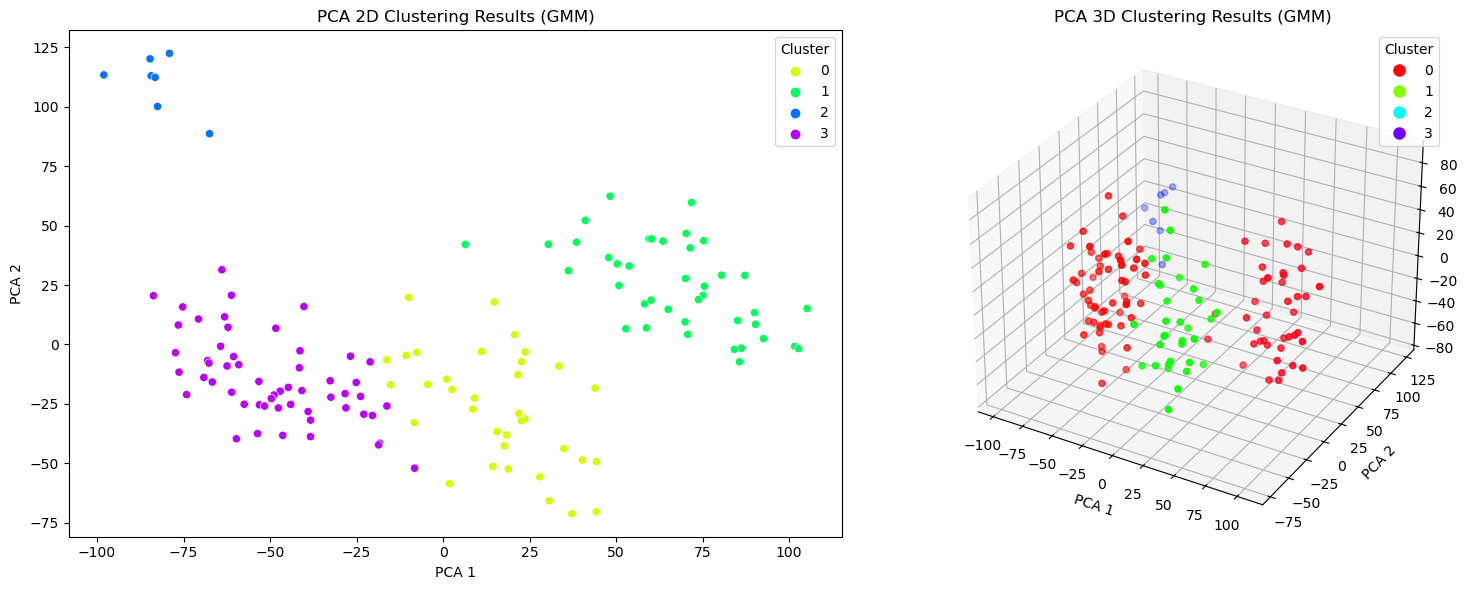

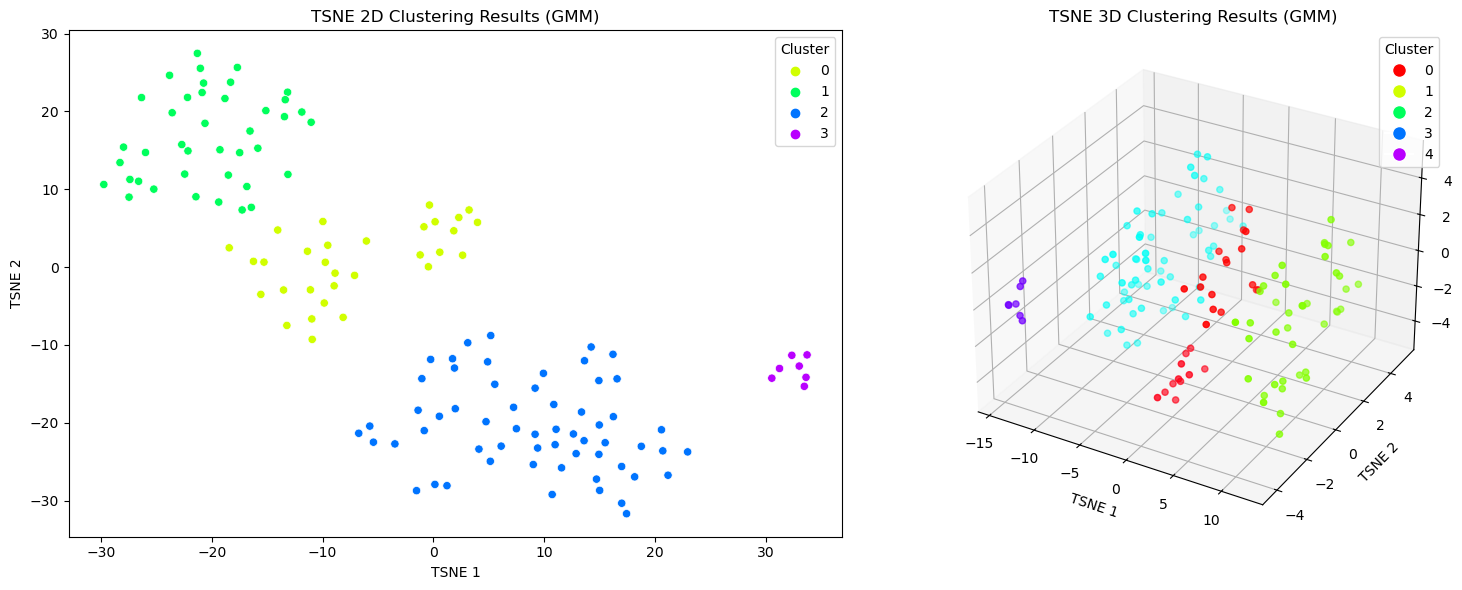

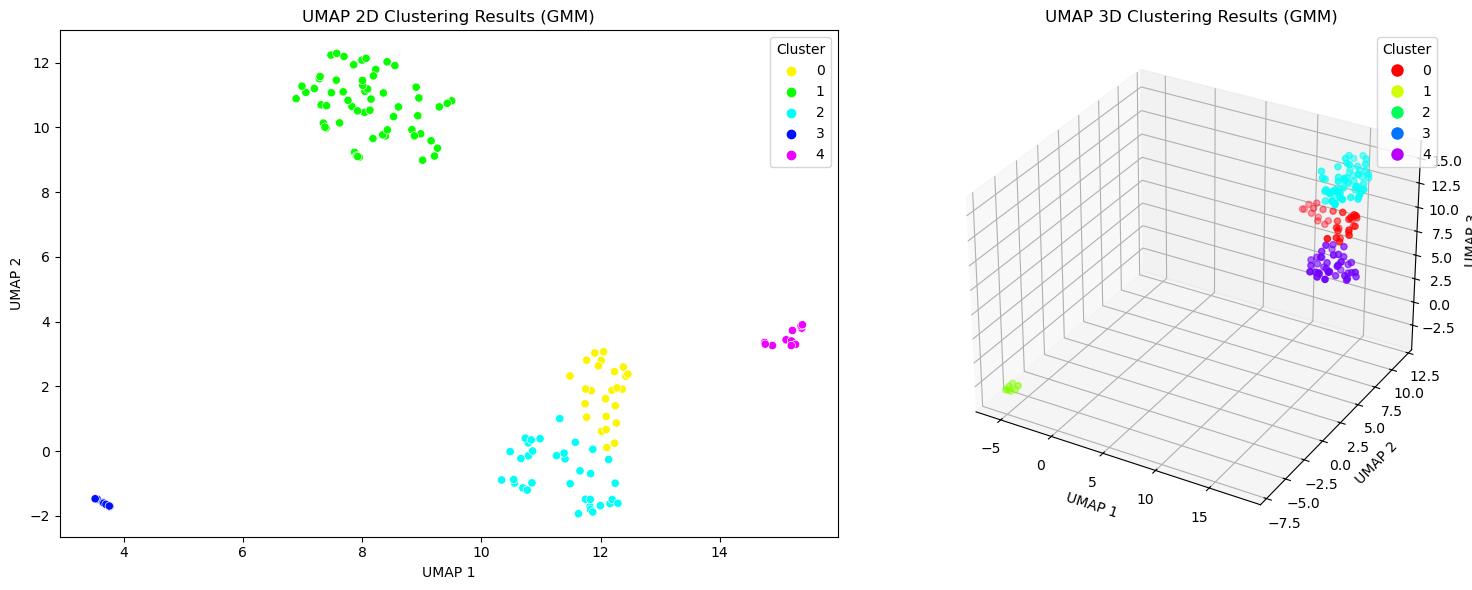

In [76]:
# Plotting GMM clustering results
data_pipeline.plot_clustering_results(clustering_algorithms=['GMM'])

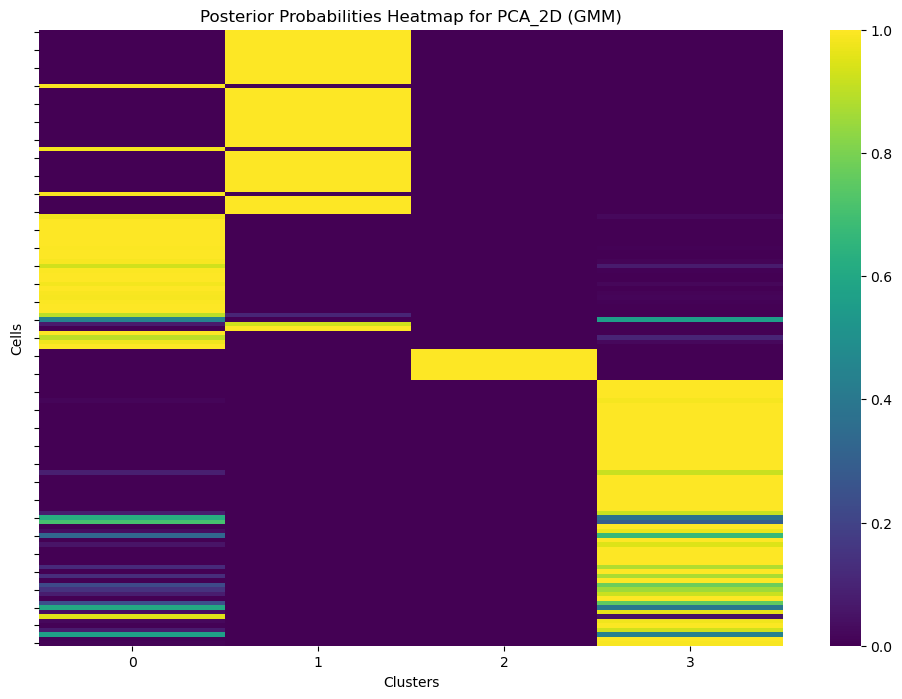

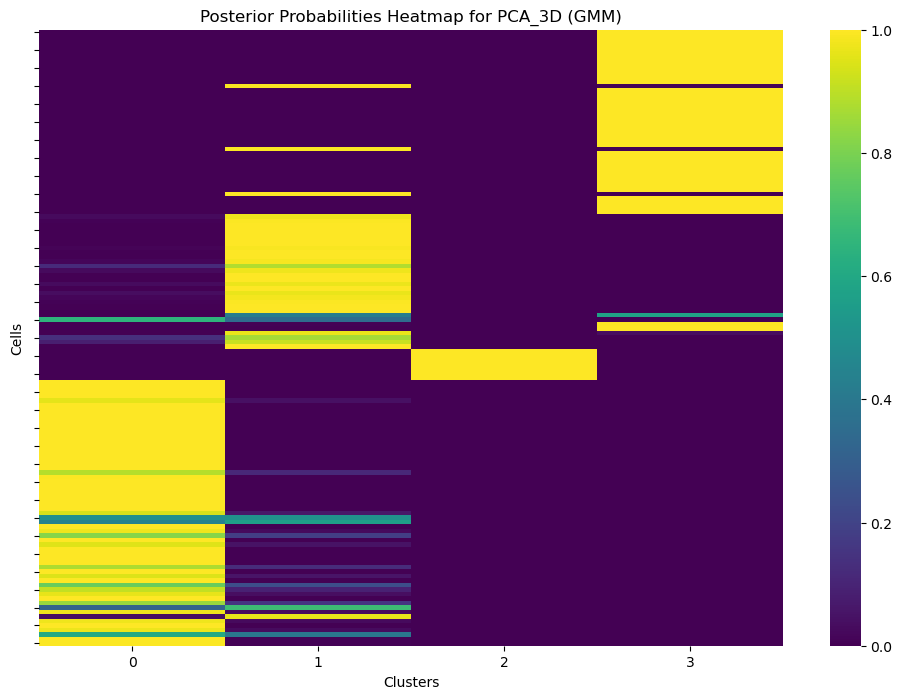

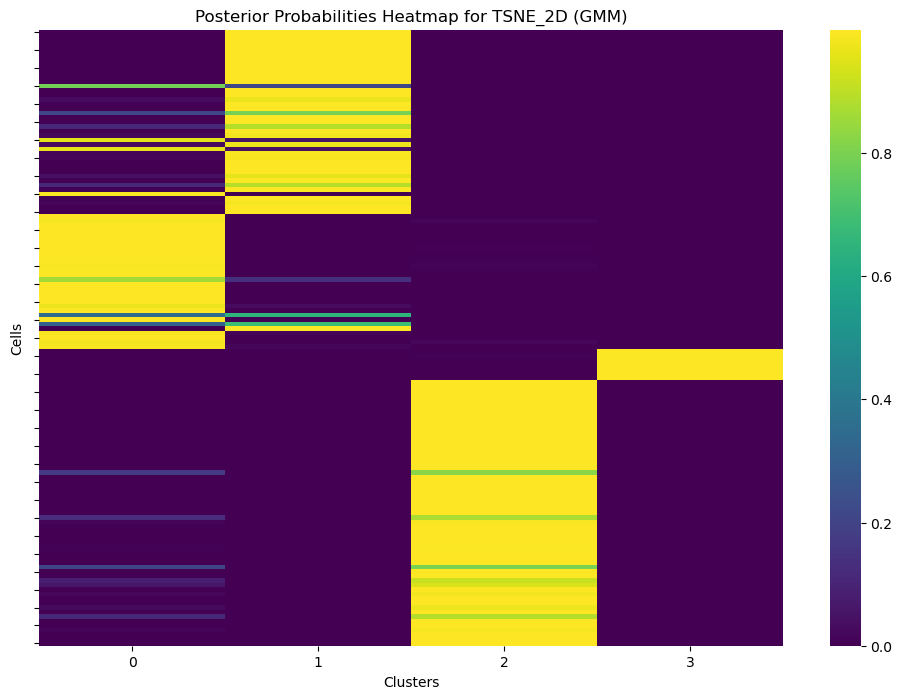

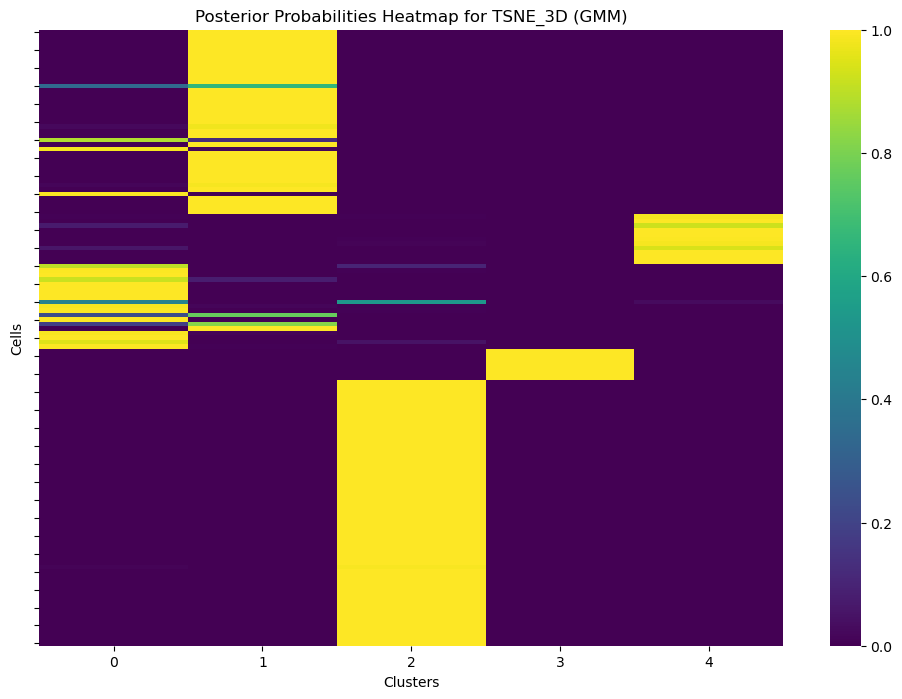

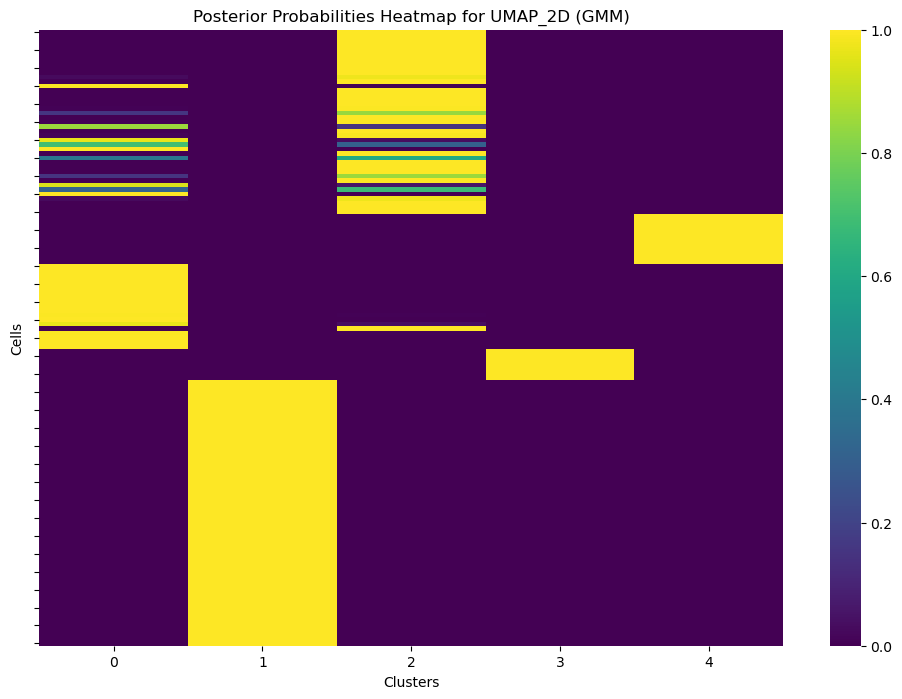

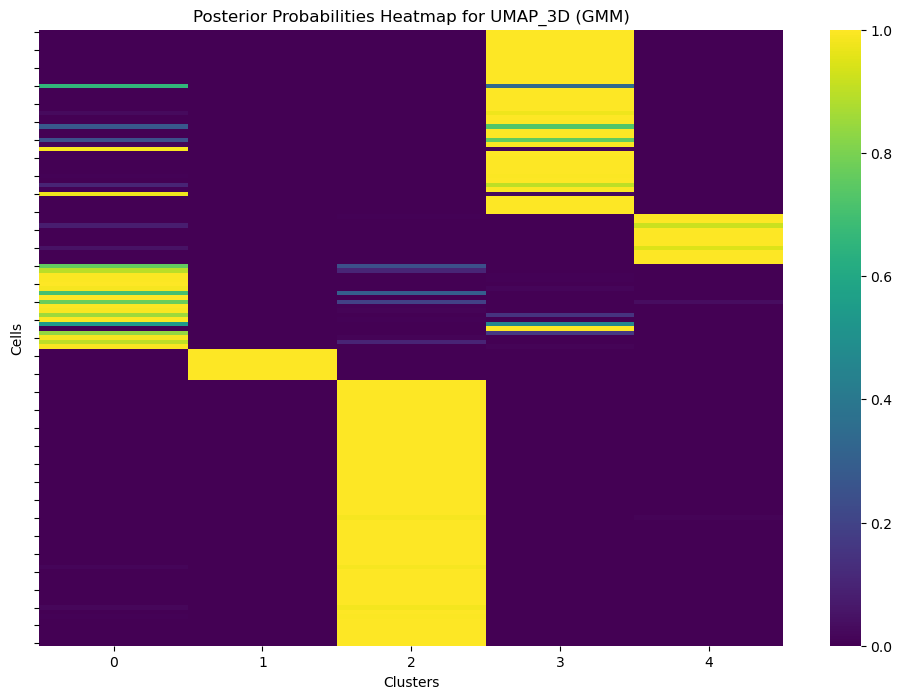

In [77]:
# Plotting GMM posterior probabilities
data_pipeline.plot_posterior_probabilities(clustering_algorithms=['GMM'])

## __BONUS__: Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a popular clustering algorithm that identifies clusters based on the density of data points. Unlike traditional clustering methods such as K-means or Gaussian Mixture Models (GMMs), DBSCAN does not require the user to specify the number of clusters beforehand. Instead, it requires two parameters: the radius within which points are considered neighbors (`eps`) and the minimum number of points required to form a dense region (cluster) (`min_samples`). DBSCAN starts with an arbitrary point and expands the cluster by adding all neighboring points within the defined radius, repeating this process for all points. This algorithm is particularly useful in single-cell RNA-seq data analysis because it can identify clusters of varying shapes and sizes, and it is robust to noise, meaning it can effectively identify and exclude outlier cells.

The Silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. The score is calculated using the mean intra-cluster distance ($a$) and the mean nearest-cluster distance ($b$) for each sample. The Silhouette score for a single sample is defined as $s = \frac{b-a}{\max(a,b)}$. In our clustering analysis, the Silhouette score is used as a model selection criterion to evaluate the quality of the clustering solutions generated by DBSCAN. By maximizing the Silhouette score, we ensure that the clusters are well-defined and distinct, providing meaningful insights into the cellular heterogeneity in single-cell RNA-seq data.

More specifically, in this implementation, for each reduced dataset, we apply DBSCAN with a range of parameters for `eps` and `min_samples` to identify the optimal clustering solution. For each combination, we calculate the Silhouette score to evaluate the quality of the resulting clusters. We select the parameter combination that yields the highest Silhouette score as the best DBSCAN model. This process is repeated for each dimensionality reduction method. We then compare the Silhouette scores of the best DBSCAN models with those of the best GMM models to systematically select the most appropriate clustering solution. Finally, we save the cluster labels from the best model in the `labels.csv` file and visualize the clustering results and posterior probabilities in 2D and 3D plots.

In [83]:
# Clustering using DBSCAN
data_pipeline.clustering(clustering_algorithms=['DBSCAN'], random_seed=89)

Clustering on PCA_2D
Clustering on PCA_3D
Clustering on TSNE_2D
Optimal number of clusters for TSNE_2D (DBSCAN): 1
Silhouette Score for TSNE_2D (DBSCAN): 0.24765454232692719
Clustering on TSNE_3D
Optimal number of clusters for TSNE_3D (DBSCAN): 10
Silhouette Score for TSNE_3D (DBSCAN): 0.26945802569389343
Clustering on UMAP_2D
Optimal number of clusters for UMAP_2D (DBSCAN): 4
Silhouette Score for UMAP_2D (DBSCAN): 0.7361782193183899
Clustering on UMAP_3D
Optimal number of clusters for UMAP_3D (DBSCAN): 2
Silhouette Score for UMAP_3D (DBSCAN): 0.8530617356300354
Best labels saved from UMAP_3D method using DBSCAN algorithm.


This output indicates that the DBSCAN algorithm is not finding any clusters for the PCA-reduced data. This can happen because the parameters for DBSCAN might not be well-suited for the PCA-reduced data, which can lead to the entire dataset being considered as noise or a single cluster, or because the structure of the PCA-reduced data might not be conducive to the density-based clustering that DBSCAN performs. In any case, we proceed with the remaining two methods.

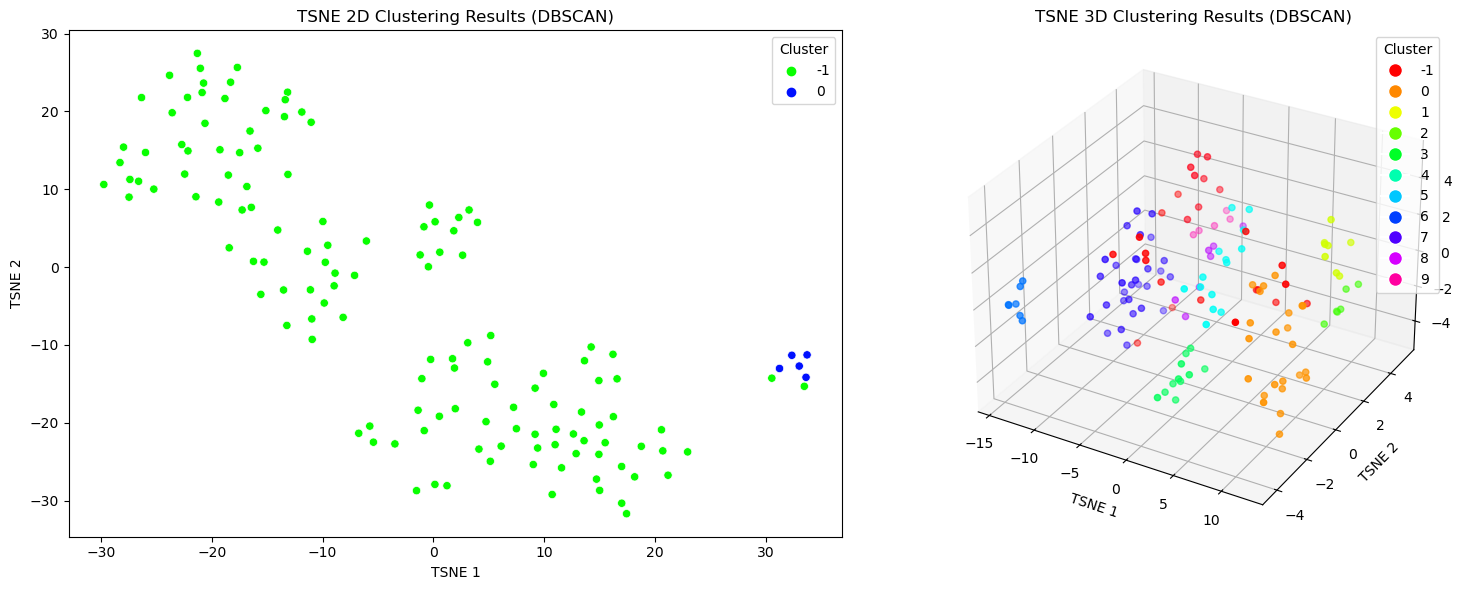

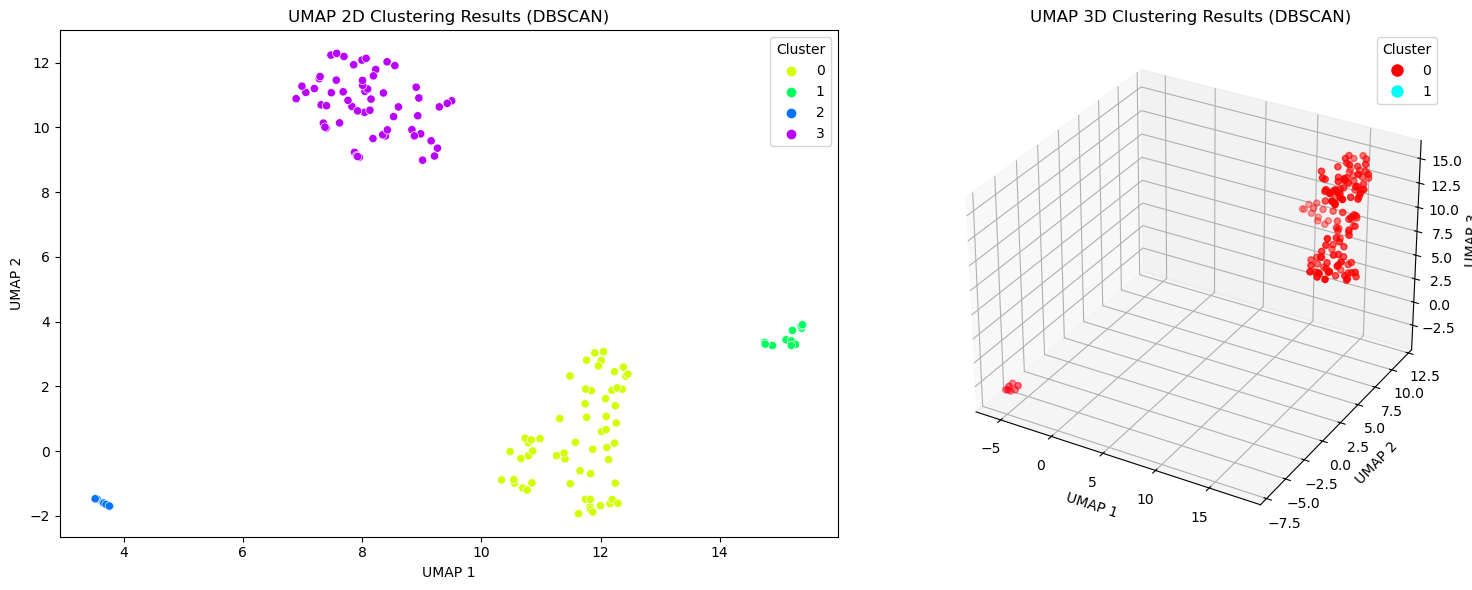

In [79]:
# Plotting DBSCAN clustering results
data_pipeline.plot_clustering_results(methods=['TSNE', 'UMAP'], clustering_algorithms=['DBSCAN'])

It is evident that only the UMAP 2D clustering produced sensible results.

# Conclusion

Based on our results, it appears that DBSCAN was not a reliable approach for clustering our data, as it failed to produce consistent and meaningful clusters across different dimensionality reduction methods. The silhouette scores obtained from DBSCAN were generally lower compared to those from the Gaussian Mixture Model (GMM), indicating poorer clustering quality. Consequently, we decided to base our final results on the output of the GMM, which demonstrated more robust performance. For instance, GMM clustering on the UMAP 2D reduced data yielded the highest silhouette score of 0.7128 and identified 5 optimal clusters, showcasing its superior ability to capture the underlying structure of the data. Therefore, we trust the GMM results and have saved the best labels from the UMAP 2D method using the GMM algorithm in the `labels.csv` file, under the `data` directory, where they can be used for comparison with the true class labels (cell types) using the Adjusted Rand Index (ARI).

Some potential improvements in our approach include:
* Alternative dimensionality reduction methods (e.g. PHATE)
* Further refinement of DBSCAN, including fine-tuning its parameters and/or experimenting with data scaling
* Alternative clustering algorithms (e.g. K-means, hierarchical methods, graph-based methods, SOMs etc.)
* Alternative model selection criteria (e.g. AIC, cross-validation etc.)
* Additional visualization techniques

### LLM Usage Notice

During this assignment, ChatGPT was used for a variety of purposes:
- Explanation of concepts to assist with further understanding and insight
- Assistance in code readability (e.g. help with adding informative comments)
- Suggestions for code error handling and bug fixing
- Task management and organization (e.g. breaking a larger task into more, smaller ones)